In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Creating empty rooms and filling it

The room is a matrix, evertything is the matrix
 - 0 = empty floor
 - 1 = trash
 - 2 = wall

The create room function takes in a size parameter, with default value = 10

The fill room function takes in the fracion of the room to be filled, default value is fill half the room = 0.5

In [3]:
# create the empty room
def create_room(size = 10):
    room = np.zeros((size, size))

    # walls
    for i in range(size):
        room[i][0] = 2
        room[i][size-1] = 2
        room[0][i] = 2
        room[size-1][i] = 2
    
    return room

# filling the room
def fill_room(room, fraction=0.5):
    # fraction of the room to be filled
    num_replaced = int(fraction*room.shape[0]*room.shape[1])

    # Random (x, y) coordinates
    indices_x = np.random.randint(1, room.shape[0]-1, num_replaced)
    indices_y = np.random.randint(1, room.shape[1]-1, num_replaced)

    room[indices_x, indices_y] = 1
    
    return room

## Example of the empty and filled room

In [4]:
room = create_room(10)
print("Empty room")
print(room)

room = fill_room(room, 0.5)
print("")
print("Filled room")
print(room)

Empty room
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
 [2. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
 [2. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
 [2. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
 [2. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
 [2. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
 [2. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
 [2. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]

Filled room
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 0. 0. 0. 1. 1. 0. 1. 0. 2.]
 [2. 0. 1. 1. 1. 1. 1. 0. 0. 2.]
 [2. 1. 1. 1. 0. 1. 0. 1. 0. 2.]
 [2. 0. 1. 0. 0. 1. 1. 1. 1. 2.]
 [2. 1. 1. 0. 0. 1. 0. 1. 1. 2.]
 [2. 1. 0. 0. 1. 1. 1. 1. 0. 2.]
 [2. 0. 1. 1. 1. 0. 1. 0. 0. 2.]
 [2. 0. 0. 1. 0. 0. 0. 1. 1. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]


## Creating the robots

Each robot is an array of lenght 3^5, with a different instruction for each combination of:
- information: wall, empty floor and trash;
- positions: above, belo, left, right and where the robot is in.

Each element in the array is a number related to the following instructions
- 0: go left
- 1: go right
- 2: go up
- 3: go down
- 4: go random direction
- 5: try to take trash

In [5]:
# create initial robots
def create_robots(number_of_robots = 10):
    robots = []
    
    for n in range(number_of_robots):
        robots.append(np.random.randint(6, size=3**5))
        
    return robots

## Update the next generation

Half of the next generation are taken from the previous one, the other are swaped genes between different robots.

All new robots pass through a mutation process, some of it's genes are randomly altered, default mutation value is 0.01 (1%)

In [6]:
# generate new robots
def swap_gene(X, Y, i):
    return np.concatenate([X[:i],Y[i:]]), np.concatenate([Y[:i],X[i:]])

def update_robots(robots, scores, mutation = 0.01):
    # sort the robots according to score and steps, score = score + steps left to max
    sorted_index = np.argsort(scores)
    
    # calculate probabilities to choose a robor, based on score
    scores += abs(min(scores))
    probs = scores/sum(scores)

    robots_to_pick = int(len(robots)/2)

    # first half chosen based on score
    
    index = np.random.choice(np.arange(len(robots)), robots_to_pick, p=probs)
    
    tmp = []
    
    for i in index:
        tmp.append(robots[i])

    # the other half, take from combination of robots from previous sessiosn
    for r in range(int( (len(robots) - robots_to_pick)/2 ) ):
        # choose two vectors to swap
        x, y = np.random.choice(np.arange(len(robots)), 2, p=probs)
        
        # rancomly choose amount of elements to swap
        g = np.random.randint(0, len(robots[x]))

        # swap them
        vec1, vec2 = swap_gene(robots[x], robots[y], g)
        
        tmp.append(vec1)
        tmp.append(vec2)
        
    # mutation
    for r in range(len(tmp)):
        new_genes = np.random.randint(0, len(robots[r]), int(mutation*len(robots[r])))

        robots[r][new_genes] = np.random.randint(7, size=1)[0]
        
        tmp.append(robots[r])

    return tmp[:len(robots)]

## Simulation

The actual simulation, one robot enters at a time in a filled room, it has 100 steps to try collect all trash. The robot starts at a random position.

In [7]:
# simulation
def simulation(room, robots, steps = 100):
    # fill the room with cans in random positions, filling a given amount of positions
    room = fill_room(room)

    scores = []

    for r in range(len(robots)):
        # start the robot at position 0,0
        x = 10
        y = 10
        score = 0

        # loop of 200 steps, stop if score = 500
        for s in range(steps+1):
            # in the loop, the informations of the environment "up, down, left, right and middle"
            # combined with the possible values "empty = 0, can = 1, wall = 2" returns a number
            # this number is the index of the array of actions

            # from the position, get the index of action
            # up, down, left, right and middle
            action = int(room[x][y+1]*3**4 + room[x][y-1]*3**3 + room[x-1][y]*3**2 + room[x+1][y]*3**1 + room[x][y])

            # create a random array of actions for each robot, 6 possible values each positino
            # 0 = go left
            if robots[r][action] == 0:
                if room[x-1][y] == 2:
                    score -= 5
                else:
                    x -= 1

            # 1 = go right
            elif robots[r][action] == 1:
                if room[x+1][y] == 2:
                    score += 5
                else:
                    x += 1

            # 2 = go up
            elif robots[r][action] == 2:
                if room[x][y+1] == 2:
                    score -= 5
                else:
                    y += 1

            # 3 = go down
            elif robots[r][action] == 3:
                if room[x][y-1] == 2:
                    score -= 5
                else:
                    y -= 1

            # 4 = go random direction
            elif robots[r][action] == 5:
                move_x = np.random.randint(-1, 2, size=1)[0]
                move_y = np.random.randint(-1, 2, size=1)[0]

                if room[x+move_x][y+move_y] == 2:
                    score -= 5
                else:
                    x += move_x
                    y += move_y

            # 5 = try take can
            elif robots[r][action] == 5:
                if room[x][y] == 1:
                    room[x][y] = 0
                    score += 10
                else:
                    score -= 1

            if score > 500:
                break

        scores.append(score+10*(steps-s))
    
    # return scores and steps
    return scores

## Running the optimization

This creates the room, fills it, creates the robots, does 50 simulations and calculates the average score of each robot. Then sends to update the new generation and stores the values to be plotted

In [8]:
# optimization

# create the room
room = create_room(20)

# create a random array of actions for each robot
robots = create_robots(100)

scores = np.zeros(len(robots))

generations = 20
average = 50

scores_list = []
av_score = []

for g in range(generations):
    # take average of scores
    for i in range(average):
        # passa actions array to the simulation
        scores += simulation(room, robots)
    
    scores /= average
    
    av_score.append(sum(scores)/len(scores))
    
    dict1 = dict( (a, sorted(scores)[a]) for a in range(len(scores)))
    scores_list.append(dict1)

    #if g % 1 == 0:
    #    print(sum(scores)/len(scores))
    #    print(sorted(scores[-5:]))

    # produce new generation
    robots = update_robots(robots, scores, 0.01)

df_scores = pd.DataFrame(scores_list, columns=range(len(scores)))

# run the simulation again for some amount of generations

## Plot

The score of all robots among many generations, the red large line is the average score of all robots.

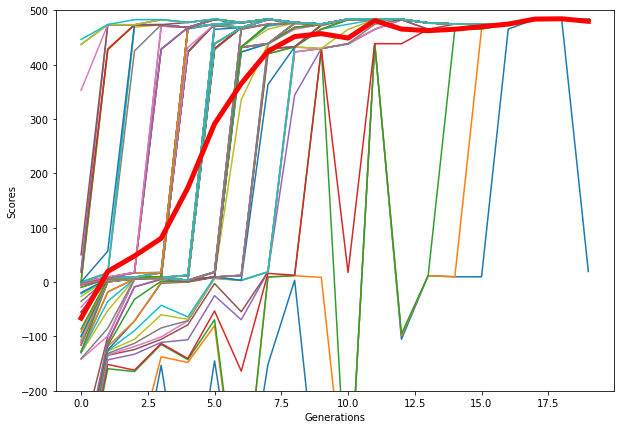

In [9]:
# plotting
plt.figure(figsize=(10, 7))
plt.plot(df_scores)
plt.plot(av_score, color='red', linewidth=5, label='average score')
plt.ylabel("Scores")
plt.xlabel("Generations")
plt.ylim([-200,500])
plt.show()